### Collecting DRS data from cricsheet

- Run the script end to end to get a list of all DRS events for a particular format

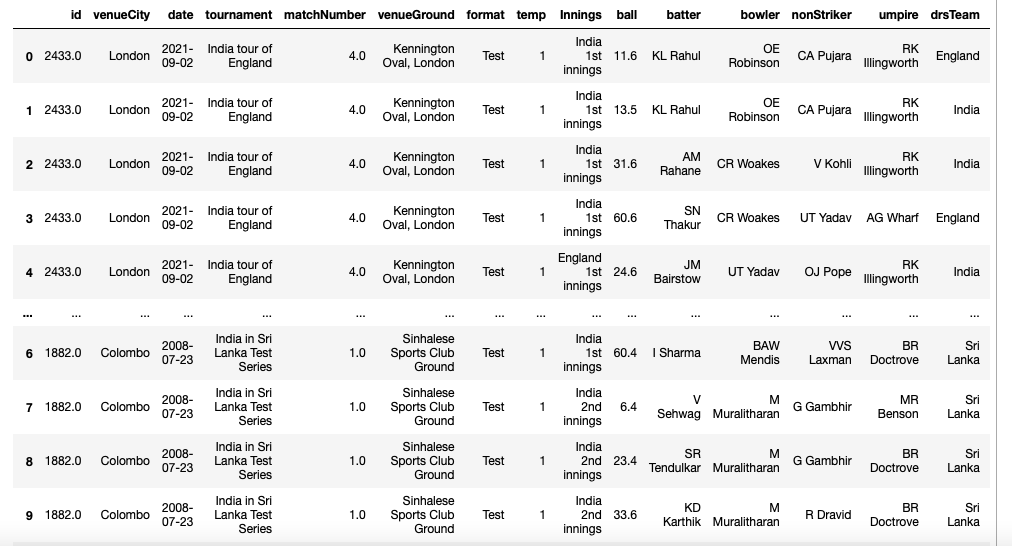

- In this script, you'll only need basic python libraries

- Cricsheet is an awesome source of data that has ball by ball review information

---



- To begin running, make sure you connect to a run time, choose the format to be one of test, odi or t20i and then run all cells

- In collab, the run time is temporary so store the output files that are generated, you'll see them under the temp folder once the script completes running

## Initialisations

In [ ]:
import pandas as pd,os,requests,json
from pathlib import Path

In [ ]:
##Choose from the right
cricket_format = "t20i" #@param ["test","odi", "t20i"]
data_path="temp/"

##source URLs of cricsheet JSON format data for different formats

test_cricsheet_files='https://cricsheet.org/downloads/tests_male_json.zip'

odi_cricsheet_files='https://cricsheet.org/downloads/odis_male_json.zip'

t20i_cricsheet_files='https://cricsheet.org/downloads/t20s_male_json.zip'

##For generating the innings list from Cricsheet, since cricsheet uses only numbers to reference
inngs_types=['1st innings','2nd innings']

p = Path(data_path).mkdir(parents=True, exist_ok=True)

##Create path

cricsheet_file_storage_path=os.path.join(data_path,cricket_format)

### Snippet to download the data onto the temp path

- Check set of files on the left, you shall see the json files under the temp and respective format folder

In [ ]:
cricsheet_file_path="{0}_cricsheet_files".format(cricket_format)

cricsheet_url=globals()[cricsheet_file_path]

Path(cricsheet_file_storage_path).mkdir(parents=True, exist_ok=True)

##Download zip files and remove them after all the necessary files have been extracted
! wget -q "$cricsheet_url"
zip_file=cricsheet_url.split('/')[-1]
! unzip -o -qq "$zip_file" -d "$cricsheet_file_storage_path"
! rm "$zip_file"

### Cricsheet has a lot of content within the README

- use the function to filter out redundant data

In [ ]:
def process_cricsheet_df(cricsheet_path):
    '''Given cricsheet Readme path, apply a set of rules to parse the correct match dataframe'''

    cricsheet_readme=pd.read_csv(os.path.join(cricsheet_path,'README.txt'),sep='\n',names=['matches'])

    ##Split using the delimiter
    cdf=cricsheet_readme['matches'].str.split('-').apply(pd.Series,1)

    ##The neeeded information for us is in the first 8 columns, so drop any row which has other kinds of information in those columns

    cdf=cdf.iloc[:,:8].dropna()

    ##Preprocess to drop more blank rows

    cricsheet_match_df=cdf.loc[cdf[0]!='']

    cricsheet_match_df.reset_index(drop=True,inplace=True)

    ##Rename the columns
    cricsheet_match_df.columns=['year','month','day','int','format','gender','cricsheet_id','cricsheet_name']

    ##Process the columns further

    cricsheet_match_df['date']=cricsheet_match_df.apply(lambda x:pd.to_datetime(x['year']+'-'+x['month']+'-'+x['day']),axis=1)

    cricsheet_match_df.drop(columns=['year','month','day'],inplace=True)

    ##Make appropriate data type conversions
    cricsheet_match_df['cricsheet_id']=cricsheet_match_df['cricsheet_id'].astype('str')

    cricsheet_match_df['date']=pd.to_datetime(cricsheet_match_df['date'])

    return cricsheet_match_df

### Get match metadata

- The below function gets the list of match metadata, mainly the venue, date, etc.

In [ ]:
def get_match_metadata(match_data):

    match_df=pd.DataFrame()
    '''Function snippet to extract match metadata from the cricsheet JSON'''

    try:
        ##Collect info variables of the game
        match_id=match_data['info']['match_type_number']
        venue_city=match_data['info']['city']
        match_date=match_data['info']['dates'][0]
        match_tournament=match_data['info']['event']['name']
        ##Handle one off tests
        match_number=match_data['info']['event']['match_number']
        venue_ground=match_data['info']['venue']
        match_format=match_data['info']['match_type']
        match_umpires=','.join(match_data['info']['officials']['umpires'])
        match_outcome=match_data['info']['outcome']
        match_mom=' '.join(match_data['info']['player_of_match'])

        match_teams=match_data['info']['teams']

        match_playing_team1=match_data['info']['players'][match_teams[0]]
        match_playing_team2=match_data['info']['players'][match_teams[1]]

        ##Get plaing X1s, then get the teams formatted
        match_teams=','.join(match_data['info']['teams'])


        toss=match_data['info']['toss']

        match_df=pd.DataFrame({'id':[match_id],'venueCity':[venue_city],'date':[match_date],
                      'tournament':[match_tournament],'matchNumber':[match_number],
                      'venueGround':[venue_ground],'format':[match_format]})


    except Exception as ex:
        pass

    return match_df

### Cricsheet innings format

- In cricsheet data, innings is represented by numbers, hence this function will be used to convert them into a better representation

In [ ]:
def generate_match_innings(match_data):
    '''From match data generate a list of match innings'''
    innings_list=[]
    match_innings=match_data['innings']
    for mn,inngs in enumerate(match_innings):
        ##First innings additions
        if mn<=1:
            current_innings=inngs['team']+' '+inngs_types[0]
            innings_list.append(current_innings)
        if mn>1:
            current_innings=inngs['team']+' '+inngs_types[1]
            innings_list.append(current_innings)
    return innings_list

### Function to parse Cricsheet JSON to collect the following information on each DRS event

- Innings number
- Ball number
- Batter
- Bowler
- Non striker
- Umpire
- Umpires call flag
- Decision of DRS
- If a wicket fell, and if so, what kind of wicket

In [ ]:
def get_drs_events_of_match(match_data):
    match_innings=generate_match_innings(match_data)
    innings_list=[]
    ball=[]
    batter=[]
    bowler=[]
    non_striker=[]
    umpire=[]
    drs_team=[]
    drs_decision=[]
    ump_call=[]
    wicket_flag=[]
    wicket_type=[]

    for inn_num,innings in enumerate(match_innings):
        for over in match_data['innings'][inn_num]['overs']:
            for deliver_num, delivery in enumerate(over['deliveries']):
                if 'review' in delivery.keys():
                    try:
                        ##Collect the innigns of DRS occurence
                        innings_list.append(innings)
                        ##Collect the ball number
                        ball.append(str(int(over['over']))+'.'+str(int(deliver_num)+1))
                        ##Collect batsman involved in DRS event
                        batter.append(delivery['review']['batter'])
                        ##Collect bowler involved in DRS event
                        bowler.append(delivery['bowler'])
                        ##Collect non striker involved in DRS event
                        non_striker.append(delivery['non_striker'])
                        ##Collect umpire involved in DRS event
                        umpire.append(delivery['review']['umpire'])
                        ##Append team that took DRS
                        drs_team.append(delivery['review']['by'])
                        ##Append the decision of the DRS
                        drs_decision.append(delivery['review']['decision'])
                        ##Append if DRS was umpires call
                        if 'umpires_call' in delivery['review'].keys():
                            ump_call.append(True)
                        else:
                            ump_call.append(False)

                        ##Check if wicket fell off this DRS call
                        if 'wickets' in delivery.keys():
                            wicket_flag.append(True)
                            ##Check what kind of dismissal this was
                            wicket_type.append(delivery['wickets'][0]['kind'])
                        else:
                            wicket_flag.append(False)
                            wicket_type.append("NA")


                    except Exception as ex:
                        innings_list.append(ex)
                        ball.append(ex)
                        batter.append(ex)
                        bowler.append(ex)
                        non_striker.append(ex)
                        umpire.append(ex)
                        drs_decision.append(ex)
                        drs_team.append(ex)
                        wicket_flag.append(ex)
                        wicket_type.append(ex)
                        ump_call.append(ex)

    drs_match_df=pd.DataFrame({'Innings':innings_list,
          'ball':ball,
          'batter':batter,
          'bowler':bowler,
          'nonStriker':non_striker,
         'umpire':umpire,
         'drsTeam':drs_team,
         'decision':drs_decision,
         'umpiresCall':ump_call,
         'wicketFlag':wicket_flag,
         'wicketType':wicket_type})

    return drs_match_df

### Collect all games of a particular format and then iterate through each of them

In [ ]:
cricsheet_match_df=process_cricsheet_df(cricsheet_file_storage_path)

match_list=[c.strip() for c in cricsheet_match_df['cricsheet_id'].values.tolist()]

In [ ]:
cricsheet_match_df

,int,format,gender,cricsheet_id,cricsheet_name,date
0,international,Test,male,1263462,England vs Australia,2021-12-08
1,international,Test,male,1277978,Pakistan vs Bangladesh,2021-12-04
2,international,Test,male,1278675,India vs New Zealand,2021-12-03
3,international,Test,male,1288346,Sri Lanka vs West Indies,2021-11-29
4,international,Test,male,1277977,Bangladesh vs Pakistan,2021-11-26
...,...,...,...,...,...,...
680,international,Test,male,64083,Pakistan vs India,2004-04-13
681,international,Test,male,64080,West Indies vs England,2004-04-10
682,international,Test,male,64076,New Zealand vs South Africa,2004-03-26
683,international,Test,male,64075,South Africa vs New Zealand,2004-03-18


### Except for few games, which have some issues in parsing, most DRS data should be available

In [ ]:
reviews_df=pd.DataFrame()
##Remove the filter to run for more games
for file in match_list:

    try:
        match_data=json.load(open(os.path.join(cricsheet_file_storage_path,"{0}.json".format(file))))

        match_df=get_match_metadata(match_data)
        match_df['temp']=1

        reviews_match_df=get_drs_events_of_match(match_data)

        reviews_match_df['temp']=1

        match_df=match_df.merge(reviews_match_df,on='temp')

        reviews_df=pd.concat([reviews_df,match_df])

    except Exception as ex:
        print("Error in processing data for match #",file)

Error in processing data for match # 1075983
Error in processing data for match # 1130745


In [ ]:
reviews_df

,id,venueCity,date,tournament,matchNumber,venueGround,format,temp,Innings,ball,batter,bowler,nonStriker,umpire,drsTeam,decision,umpiresCall,wicketFlag,wicketType
0,2440.0,Brisbane,2021-12-08,The Ashes,1.0,"Brisbane Cricket Ground, Woolloongabba, Brisbane",Test,1,England 1st innings,34.2,JC Buttler,MA Starc,OJ Pope,RJ Tucker,Australia,struck down,0.0,0.0,NA
1,2440.0,Brisbane,2021-12-08,The Ashes,1.0,"Brisbane Cricket Ground, Woolloongabba, Brisbane",Test,1,Australia 1st innings,50.2,SPD Smith,MA Wood,DA Warner,RJ Tucker,England,struck down,0.0,0.0,NA
2,2440.0,Brisbane,2021-12-08,The Ashes,1.0,"Brisbane Cricket Ground, Woolloongabba, Brisbane",Test,1,England 2nd innings,0.6,RJ Burns,MA Starc,H Hameed,PR Reiffel,England,upheld,0.0,0.0,NA
3,2440.0,Brisbane,2021-12-08,The Ashes,1.0,"Brisbane Cricket Ground, Woolloongabba, Brisbane",Test,1,England 2nd innings,22.5,DJ Malan,JR Hazlewood,JE Root,PR Reiffel,Australia,struck down,0.0,0.0,NA
4,2440.0,Brisbane,2021-12-08,The Ashes,1.0,"Brisbane Cricket Ground, Woolloongabba, Brisbane",Test,1,Australia 2nd innings,1.5,MS Harris,CR Woakes,AT Carey,PR Reiffel,England,struck down,0.0,0.0,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,1882.0,Colombo,2008-07-23,India in Sri Lanka Test Series,1.0,Sinhalese Sports Club Ground,Test,1,India 1st innings,60.4,I Sharma,BAW Mendis,VVS Laxman,BR Doctrove,Sri Lanka,struck down,0.0,0.0,NA
7,1882.0,Colombo,2008-07-23,India in Sri Lanka Test Series,1.0,Sinhalese Sports Club Ground,Test,1,India 2nd innings,6.4,V Sehwag,M Muralitharan,G Gambhir,MR Benson,Sri Lanka,upheld,0.0,1.0,lbw
8,1882.0,Colombo,2008-07-23,India in Sri Lanka Test Series,1.0,Sinhalese Sports Club Ground,Test,1,India 2nd innings,23.4,SR Tendulkar,M Muralitharan,G Gambhir,BR Doctrove,Sri Lanka,upheld,0.0,1.0,caught
9,1882.0,Colombo,2008-07-23,India in Sri Lanka Test Series,1.0,Sinhalese Sports Club Ground,Test,1,India 2nd innings,33.6,KD Karthik,M Muralitharan,R Dravid,BR Doctrove,Sri Lanka,struck down,0.0,0.0,NA


### Store the results in the temp folder on the left in google colab

In [ ]:
reviews_df.to_excel(os.path.join(data_path,'reviews.xlsx'),index=False)